# RHF 一阶 U 矩阵与二阶 U 矩阵

这一节我们专门讨论一阶 U 矩阵与二阶 U 矩阵的生成与性质．

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from pyscf import scf, gto, lib, grad, hessian, dft
from functools import partial
from utilities import val_from_fchk
from hf_helper import HFHelper
from numeric_helper import NumericDiff

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(5, linewidth=150, suppress=True)

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

grids = dft.gen_grid.Grids(mol)
grids.atom_grid = (99, 590)
grids.becke_scheme = dft.gen_grid.stratmann
grids.prune = None
grids.build()

nmo = nao = mol.nao
natm = mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so = slice(0, nocc)
sv = slice(nocc, nmo)
sa = slice(0, nmo)

In [4]:
hfh = HFHelper(mol)
hfh.get_grad()
hfh.get_hess()

scf_eng  = hfh.scf_eng
scf_grad = hfh.scf_grad
scf_hess = hfh.scf_hess

C       = hfh.C
Co      = hfh.Co
Cv      = hfh.Cv
e       = hfh.e
eo      = hfh.eo
ev      = hfh.ev
D       = hfh.D
F_0_ao  = hfh.F_0_ao
F_0_mo  = hfh.F_0_mo
H_0_ao  = hfh.H_0_ao
H_0_mo  = hfh.H_0_mo
eri0_ao = hfh.eri0_ao
eri0_mo = hfh.eri0_mo
mo_occ  = hfh.mo_occ
H_1_ao  = hfh.H_1_ao
H_1_mo  = hfh.H_1_mo
S_1_ao  = hfh.S_1_ao
S_1_mo  = hfh.S_1_mo
F_1_ao  = hfh.F_1_ao
F_1_mo  = hfh.F_1_mo
eri1_ao = hfh.eri1_ao
eri1_mo = hfh.eri1_mo
H_2_ao  = hfh.H_2_ao
H_2_mo  = hfh.H_2_mo
S_2_ao  = hfh.S_2_ao
S_2_mo  = hfh.S_2_mo
F_2_ao  = hfh.F_2_ao
F_2_mo  = hfh.F_2_mo
eri2_ao = hfh.eri2_ao
eri2_mo = hfh.eri2_mo
B_1     = hfh.B_1
U_1     = hfh.U_1
Xi_2    = hfh.Xi_2
B_2_vo  = hfh.B_2_vo
U_2_vo  = hfh.U_2_vo

Ax0_Core = hfh.Ax0_Core
Ax1_Core = hfh.Ax1_Core
mol_slice = hfh.mol_slice

/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:221: UserWarning: eri0_ao: ERI should not be stored in memory! Consider J/K engines!
  warnings.warn("eri0_ao: ERI should not be stored in memory! Consider J/K engines!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:228: UserWarning: eri0_mo: ERI AO -> MO is quite expensive!
  warnings.warn("eri0_mo: ERI AO -> MO is quite expensive!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:271: UserWarning: eri1_ao: 4-idx tensor ERI should be not used!
  warnings.warn("eri1_ao: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:278: UserWarning: eri1_mo: 4-idx tensor ERI should be not used!
  warnings.warn("eri1_mo: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:309: UserWarning: eri2_ao: 4-idx tensor ERI should be not used!
  warnings.warn("eri2_ao: 4-idx tensor ERI should b

## 实现参考：一阶 U 矩阵

### $B_{pq}^{A_t}$

Yamaguchi (p437, X.3)

$$
B_{pq}^{A_t} = F_{pq}^{A_t} - S_{pq}^{A_t} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^{A_t}
$$

该矩阵的非占-占据部分会作为 CP-HF 方程的等式左出现．

In [5]:
np.allclose(
    F_1_mo - S_1_mo * e - 0.5 * Ax0_Core(sa, sa, so, so)(S_1_mo[:, :, so, so]),
    B_1
)

True

遗憾的是，该矩阵一般来说是不能验证的；它只作为 CP-HF 方程的 RHS 出现．

### 一阶 U 矩阵非占-占据部分 $U_{ai}^{A_t}$

Yamaguchi (p437, X.1)

$$
- (\varepsilon_p - \varepsilon_q) U_{pq}^{A_t} - A_{pq, bj} U_{bj}^{A_t} = B_{pq}^{A_t} \quad (p \neq q)
$$

但是需要注意到，上式若作为作为线性方程，其可以求解的区间只能是非占-占据部分；剩余的部分在获得非占-占据部分后，仍然需要通过下面的式子求取：

Yamaguchi (p132, 10.26)

$$
U_{pq}^{A_t} = - \frac{1}{\varepsilon_p - \varepsilon_q} (A_{pq, bj}^{A_t} U_{bj}^{A_t} + B_{pq}^{A_t}) \quad (p \neq q)
$$

注意到上式中 $p \neq q$，这是因为 CP-HF 方程是由 $\frac{\partial}{\partial {A_t}} F_{pq} = 0$ 当 $p \neq q$ 而来．对于 $p = q$ 的情况，我们可以利用下述关系式：

Yamaguchi (p402, J.2)

$$
S_{pq}^{A_t} + U_{pq}^{A_t} + U_{qp}^{A_t} = 0
$$

因此，

$$
U_{pp}^{A_t} = - \frac{1}{2} S_{pp}^{A_t}
$$

我们在这一小节中处理非占-占据部分．

#### 矩阵求逆

这个问题实际上可以化为线性问题 

$$
(- A_{ai, bj} - \delta_{ab} \delta_{ij} (\varepsilon_a - \varepsilon_i)) U_{bj}^{A_t} = B_{ai}^{A_t}
$$

我们可以考虑先构建张量 
$$
A_{ai, bj}' = - A_{ai, bj} - \delta_{ab} \delta_{ij} (\varepsilon_b - \varepsilon_j))
$$

随后将 $ai, bj$ 分别当成一个维度，通过
$$
U_{ai}^{A_t} = (\mathbf{A}')^{-1}_{ai, bj} B_{bj}^{A_t}
$$

求逆来获得一阶 U 矩阵的非占-占据部分．

尽管显然这是非常低效的做法：为了生成 MO 基组的 $(A_{ai, bj})$ 我们需要使用 $O(N^5)$ 的计算量；而为了计算数值的 $(\mathbf{A}')^{-1}_{ai, bj}$ 我们还需要 $O(N^6)$ 计算量．但是这是几乎不需要调用更复杂或者更高级函数的过程，因此作为模型过程，我们对其程序化如下．

首先，我们生成 `AprimeTensor` $A_{ai, bj}'$：

In [6]:
AprimeTensor = (
    - 4 * eri0_mo[sv, so, sv, so]
    + np.einsum("abij -> aibj", eri0_mo[sv, sv, so, so])
    + np.einsum("ajib -> aibj", eri0_mo[sv, so, so, sv])
    - np.eye(nvir)[:, None, :, None] * np.eye(nocc)[None, :, None, :] * (ev[:, None] - eo[None, :])
)

为了作矩阵求逆，我们需要将原先的四维张量化为二维．为了方便，这里简单地把化简后的问题称作 $\mathbf{A} \boldsymbol{x} = \boldsymbol{b}$；并令 LHS 的四维张量 $A_{ai, bj}'$ 在这里等价于 `A` $\mathbf{A}$，而 RHS 的向量 $B_{bj}^{A_t}$ 在这里等价于 `b` $\boldsymbol{b}$：

In [7]:
A = AprimeTensor.reshape(nvir * nocc, nvir * nocc)
b = B_1[:, :, sv, so].reshape(natm, 3, nvir * nocc)

随后，`U_1_byinv` U 矩阵就可以通过求逆运算得到；最后我们把原先一维的向量转为非占-占据的二维矩阵就可以了．

In [8]:
U_1_byinv = np.einsum("ij, Atj -> Ati", np.linalg.inv(A), b).reshape(natm, 3, nvir, nocc)

旋即我们可以验证刚刚我们生成的 `U_1_byinv` 与 HFHelper 所给出的 `U_1` 的结果是否相同：

In [9]:
np.allclose(U_1_byinv, U_1[:, :, sv, so])

True

#### SciPy 库求解

一般来说，这一类 (线性或非线性) 问题可以由固定的方式求解；如果我们可以合理定义下述关系：

$$
f_{ai} [U_{bj}^{A_t}] = B_{ai}^{A_t}
$$

其中，$f_{ai}$ 是一个作用于矩阵的算符 (也许可以是函数，泛函或者高维张量，不管怎样，程序实现中就是一个普通的函数)．

在 SciPy 中，其中一种解决方案是 `scipy.optimize.newton_krylov`：

In [10]:
scipy.optimize.newton_krylov

<function scipy.optimize.nonlin.newton_krylov(F, xin, iter=None, rdiff=None, method='lgmres', inner_maxiter=20, inner_M=None, outer_k=10, verbose=False, maxiter=None, f_tol=None, f_rtol=None, x_tol=None, x_rtol=None, tol_norm=None, line_search='armijo', callback=None, **kw)>

我们需要为其代入至少两个变量，其中一者是 RHS 的 $B_{ai}^{A_t}$；而另一者是函数 `g`，它代表的意义是

$$
g_{ai} [U_{bj}^{A_t}] = f_{ai} [U_{bj}^{A_t}] - B_{ai}^{A_t} = - (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t} - A_{ai, bj} U_{bj}^{A_t} - B_{ai}^{A_t}
$$

In [11]:
def g(U):
    return (
        - (ev[:, None] - eo[None, :]) * U
        - Ax0_Core(sv, so, sv, so)(U)
        - B_1[:, :, sv, so]
    )

这个 SciPy 函数的目标即是求解 `U_1_byscipy` $U_{ai}^{A_t}$，使得 $g_{ai} [U_{bj}^{A_t}] = 0$：

In [12]:
U_1_byscipy = scipy.optimize.newton_krylov(g, B_1[:, :, sv, so])

我们也可以验证其与 HFHelper 的 `U_1` 是否是相同的：

In [13]:
np.allclose(U_1_byscipy, U_1[:, :, sv, so], atol=1e-6)

True

两者多少还有一些误差．事实上，我们还有另一种办法判断 CP-HF 方程的误差大小．既然我们刚才求解的目标是使 $g_{ai} [U_{bj}^{A_t}] = 0$，那么我们只要判断 $g_{ai} [U_{bj}^{A_t}]$ 与 零的相似程度即可：

In [14]:
print("Maximum Absolute Deviation:")
print("HFHelper : {:10.4E}".format(abs(g(U_1[:, :, sv, so])).max()))
print("Inversion: {:10.4E}".format(abs(g(U_1_byinv)).max()))
print("SciPy    : {:10.4E}".format(abs(g(U_1_byscipy)).max()))

Maximum Absolute Deviation:
HFHelper : 2.3272E-10
Inversion: 1.2167E-13
SciPy    : 2.4486E-07


很明显地，通过矩阵求逆得到的结果要好不少，精度已经在一般的机器精度 2e-15 左右；但代价也非常高．对于其它两种方法的精度，应当认为 SciPy 的方法精度更高．(但若修改过 PySCF 的配置文件，HFHelper 的精度可以更高)

#### PySCF 库函数求解

在 PySCF 中，可以使用 `pyscf.scf.cphf` 中的方法来计算 CP-HF 方程．

In [15]:
scf.cphf.solve

<function pyscf.scf.cphf.solve(fvind, mo_energy, mo_occ, h1, s1=None, max_cycle=20, tol=1e-09, hermi=False, verbose=2)>

该函数需要调入的是获得 $A_{ai, bj}^{A_t} U_{bj}^{A_t}$ 所需要的函数 (在 HFHelper 中就是 `Ax0_Core`)、轨道能、占据数与 RHS 的 $B_{ai}^{A_t}$．

In [16]:
U_1_bypyscf = scf.cphf.solve(
    Ax0_Core(sv, so, sv, so),
    e,
    mo_occ,
    B_1[:, :, sv, so]
)[0]

事实上，在现在的 HFHelper 中，求解 U 矩阵的实现方法就是通过 PySCF 的库函数得到．因此，其误差也与 HFHelper 的误差相当．

In [17]:
print("SciPy    : {:10.4E}".format(abs(g(U_1_bypyscf)).max()))

SciPy    : 6.9466E-07


<div class="alert alert-info">

**任务**

1. (可选) 尝试对上面提到的三种方法的计算耗时作评估．你可能能发现 PySCF 处理当前体系的效率非常高．

2. (可选) 请尝试在不更改库函数的情况下，提高 SciPy 求解与 PySCF 求解 CP-HF 方程的精度，并以上述定义的 `g` 函数查看精度．

    * 提示：SciPy 方法求解可以通过更改可选参数来提高精度．请查看官方文档查看参数详情．
   
    * 提示：PySCF 方法则会麻烦一些．更改可选参数未必会真正提高计算精度．你可能需要查看 `pyscf/lib/linalg_helper.py` 与 `pyscf/__config__.py` 文件获取帮助．

</div>

### 一阶 U 矩阵：全轨道 $U_{pq}^{A_t}$

在有了一阶 U 矩阵的非占-占据部分后，整个的 U 矩阵就是可求的；公式在上一小节中已经描述了．我们下面用代码生成这部分矩阵．

中间量 `D_pq`

\begin{align}
D_{p}^{q} &= \varepsilon_p - \varepsilon_q \quad (p \neq q) \\
D_{p}^{p} &= \infty
\end{align}

In [18]:
D_pq = e[:, None] - e[None, :] + np.diag(np.ones(nmo) * np.inf)
U_1_ = (
    - 1 / D_pq * (Ax0_Core(sa, sa, sv, so)(U_1[:, :, sv, so]) + B_1)
    - 0.5 * S_1_mo * np.eye(nmo)[None, None, :, :]
)
np.allclose(U_1_, U_1, atol=1e-7)

True

同时，U 矩阵还满足下述关系式：

Yamaguchi (p402, J.2)

$$
S_{pq}^{A_t} + U_{pq}^{A_t} + U_{qp}^{A_t} = 0
$$

In [19]:
np.allclose(U_1 + U_1.swapaxes(-1, -2), -S_1_mo)

True

<div class="alert alert-warning">

**提醒**

很显然，如果存在简并的占据或者非占轨道，那么就存在 $\varepsilon_p - \varepsilon_q = 0$ 的情况；因此，$U_{pq}^{A_t}$ 并不是数值上稳定的．在工业化的量化计算方法中，一般来说不应该出现 $U_{ij}^{A_t}$ 与 $U_{ab}^{A_t}$．

当然，我们也许会说 $U_{ii}^{A_t}$ 或 $U_{aa}^{A_t}$ 应当是允许的，因为他们可以由 $-\frac{1}{2} S_{pp}^{A_t}$ 计算得来．同时，一般不认为 $U_{ai}^{A_t}$ 或 $U_{ia}^{A_t}$ 是数值不稳定的．

</div>

### 一阶 U 矩阵：数值方法

U 矩阵一般来说可以通过数值方法得到；尽管通常难以达到满意的精度．

Yamaguchi (p398, G.1)

$$
\frac{\partial}{\partial A_t} C_{\mu q} = U_{pq}^{A_t} C_{\mu p}
$$

如果我们现在把 $\frac{\partial}{\partial A_t} C_{\mu q}$ 当作一个矩阵，并且利用现在体系下原子轨道与分子轨道数相等的条件，那么 $U_{pq}^{A_t}$ 实际上可以通过求逆的方法得到：

$$
U_{pq}^{A_t} = (\mathbf{C}^{-1})_{p \mu} \frac{\partial}{\partial A_t} C_{\mu q}
$$

In [20]:
C_diff = NumericDiff(mol, lambda mol : HFHelper(mol).C, p5=True, interval=1e-3).get_numdif()
U_1_num = np.linalg.inv(C) @ C_diff

但从精度来看，需要把判断阈值设得比较大才能通过：

In [21]:
np.allclose(U_1_num, U_1, atol=5e-6, rtol=1e-4)

True

我们能查看数值导出的 U 矩阵与解析的 U 矩阵的误差：

In [22]:
print("Max Absolute Deviation: {:10.4E}".format(abs(U_1_num - U_1).max()))
print("Avg Absolute Deviation: {:10.4E}".format(abs(U_1_num - U_1).sum() / U_1.size))

Max Absolute Deviation: 6.4977E-06
Avg Absolute Deviation: 1.5819E-08


我们还可以绘制一张误差图，它的横坐标是解析与数值 U 矩阵的偏差大小，纵坐标是处于这部分偏差的矩阵元素数量．我们能发现，绝大多数元素的偏差值都在 1e-7 的量级或者以下，因此解析与数值矩阵实际上还是相近的．

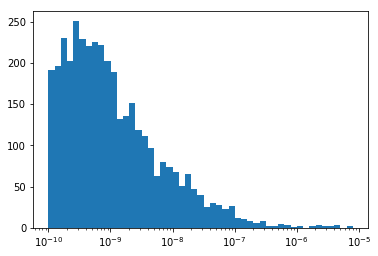

In [23]:
plt.hist(abs(U_1_num - U_1).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(8e-6), 50))
plt.gca().set_xscale("log")

在实践过程中，发现解析与数值 U 矩阵较大的误差一般是由于 SCF 收敛不够准确导致的．提高 SCF 收敛精度将会大大提高与 U 矩阵有关的梯度性质的数值精度．

## 实现参考：二阶 U 矩阵

### $\xi_{pq}^{A_t B_s}$

这里暂时用 $m$ 表示任意分子轨道的角标，类同于 $p, q$．

Yamaguchi (p405, L.4)

$$
\xi_{pq}^{A_t B_s} = S_{pq}^{A_t B_s} + U_{pm}^{A_t} U_{qm}^{B_s} + U_{pm}^{B_s} U_{qm}^{A_t} - S_{pm}^{A_t} S_{qm}^{B_s} - S_{pm}^{B_s} S_{qm}^{A_t}
$$

In [24]:
np.allclose(
    + S_2_mo
    + np.einsum("Atpm, Bsqm -> ABtspq", U_1, U_1)
    + np.einsum("Bspm, Atqm -> ABtspq", U_1, U_1)
    - np.einsum("Atpm, Bsqm -> ABtspq", S_1_mo, S_1_mo)
    - np.einsum("Bspm, Atqm -> ABtspq", S_1_mo, S_1_mo),
    Xi_2
)

True

该矩阵只是中间矩阵，也没有验证手段．

### $B_{ai}^{A_t B_s}$

由于在实际应用中，我们无需求取非占-占据部分以外的二阶 CP-HF 方程的 RHS；因此，我们就只生成非占-占据部分的矩阵．

Yamaguchi (p437-438, X.5)

\begin{align}
B_{ai}^{A_t B_s} &= F_{ai}^{A_t B_s} - \xi_{ai}^{A_t B_s} \varepsilon_i - \frac{1}{2} A_{ai, kl} \xi_{kl}^{A_t B_s} \\
&\quad\mathrel+ U_{pa}^{A_t} F_{pi}^{B_s} + U_{pa}^{B_s} F_{pi}^{A_t} + U_{pi}^{A_t} F_{pa}^{B_s} + U_{pi}^{B_s} F_{pa}^{A_t} \\
&\quad\mathrel+ U_{pa}^{A_t} U_{pi}^{B_s} \varepsilon_p + U_{pa}^{B_s} U_{pi}^{A_t} \varepsilon_p \\
&\quad\mathrel+ A_{ai, pq} U_{pk}^{A_t} U_{qk}^{B_s} \\
&\quad\mathrel+ U_{pa}^{A_t} A_{pi, qm} U_{qm}^{B_s} + U_{pa}^{B_s} A_{pi, qm} U_{qm}^{A_t} \\
&\quad\mathrel+ U_{pi}^{A_t} A_{pa, qm} U_{qm}^{B_s} + U_{pi}^{B_s} A_{pa, qm} U_{qm}^{A_t} \\
&\quad\mathrel+ A_{ai, pk}^{A_t} U_{pk}^{B_s} + A_{ai, pk}^{B_s} U_{pk}^{A_t}
\end{align}

公式非常冗杂．尽管在以后，我们还会在二阶非自洽梯度的情景下作一些化简；但在现在，我还想不到利用 $A_t$ 与 $B_s$ 对称性以外的化简方式．下述的实现方式没有对 $A_t, B_s$ 的对称性作简化．

In [25]:
B_2_vo_ = (
    np.einsum("ABtsuv, ua, vi -> ABtsai", F_2_ao, Cv, Co)
    - np.einsum("ABtsai, i -> ABtsai", Xi_2[:, :, :, :, sv, so], eo)
    - 0.5 * Ax0_Core(sv, so, so, so)(Xi_2[:, :, :, :, so, so])
    # line 2
    + np.einsum("Atpa, Bspi -> ABtsai", U_1[:, :, :, sv], F_1_mo[:, :, :, so])
    + np.einsum("Bspa, Atpi -> ABtsai", U_1[:, :, :, sv], F_1_mo[:, :, :, so])
    + np.einsum("Atpi, Bspa -> ABtsai", U_1[:, :, :, so], F_1_mo[:, :, :, sv])
    + np.einsum("Bspi, Atpa -> ABtsai", U_1[:, :, :, so], F_1_mo[:, :, :, sv])
    # line 3
    + np.einsum("Atpa, Bspi, p -> ABtsai", U_1[:, :, :, sv], U_1[:, :, :, so], e)
    + np.einsum("Bspa, Atpi, p -> ABtsai", U_1[:, :, :, sv], U_1[:, :, :, so], e)
    # line 4
    + Ax0_Core(sv, so, sa, sa)(np.einsum("Atpk, Bsqk -> ABtspq", U_1[:, :, :, so], U_1[:, :, :, so]))
    # line 5
    + np.einsum("Atpa, Bspi -> ABtsai", U_1[:, :, :, sv], Ax0_Core(sa, so, sa, so)(U_1[:, :, :, so]))
    + np.einsum("Bspa, Atpi -> ABtsai", U_1[:, :, :, sv], Ax0_Core(sa, so, sa, so)(U_1[:, :, :, so]))
    # line 6
    + np.einsum("Atpi, Bspa -> ABtsai", U_1[:, :, :, so], Ax0_Core(sa, sv, sa, so)(U_1[:, :, :, so]))
    + np.einsum("Bspi, Atpa -> ABtsai", U_1[:, :, :, so], Ax0_Core(sa, sv, sa, so)(U_1[:, :, :, so]))
    # line 7
    + Ax1_Core(sv, so, sa, so)(U_1[:, :, :, so])
    + Ax1_Core(sv, so, sa, so)(U_1[:, :, :, so]).transpose(1, 0, 3, 2, 4, 5)
)
np.allclose(B_2_vo_, B_2_vo)

True

遗憾的是 $B_{ai}^{A_t B_s}$ 也是几乎无法验证的．可以验证其是否正确的方法几乎只有将其代入二阶 CP-HF 方程，检验二阶 U 矩阵是否生成正确．

<div class="alert alert-warning">

**提醒**

$B_{ai}^{A_t B_s}$ 中包含了非对角元的 $U_{ij}^{A_t}$ 与 $U_{ab}^{A_t}$ 的贡献．这会导致计算过程中的数值不稳定．我曾经尝试化简过 $B_{ai}^{A_t B_s}$ 以消去 $U_{ij}^{A_t}$ 与 $U_{ab}^{A_t}$，或转化为 $S_{pq}^{A_t B_s}$ 的贡献，但后来认为这是不可能的．

因此，在这里断言若出现占据或非占轨道简并的情况，$B_{ai}^{A_t B_s}$ 是数值不稳定的．工业化的量化方法不应当出现 $B_{ai}^{A_t B_s}$ 式，也因此二阶 CP-HF 方程是需要避免的．这**不是**计算量的角度的问题．

在之后的笔记中我们还会回到这个问题．

</div>

### 二阶 U 矩阵 $U_{ai}^{A_t}$

事实上二阶 CP-HF 方程与一阶近乎相同．因此，从实现上，这两者也没有本质的区别．

Yamaguchi (p437, X.4)

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t B_s} - A_{ai, bj} U_{bj}^{A_t B_s} = B_{pq}^{A_t B_s}
$$

In [26]:
U_2_vo_ = scf.cphf.solve(
    Ax0_Core(sv, so, sv, so),
    e,
    mo_occ,
    B_2_vo
)[0]
np.allclose(U_2_vo_, U_2_vo)

True

与一阶 U 矩阵一样，二阶 U 矩阵可以通过数值方法验证；但误差一样很大．需要注意的是，$\frac{\partial}{\partial B_s} U_{pq}^{A_t}$ 并不是 $A_t, B_s$ 对称的．

Yamaguchi (p399, H.1)

$$
\frac{\partial}{\partial B_s} U_{pq}^{A_t} = U_{pq}^{A_t B_s} - U_{pm}^{B_s} U_{mq}^{A_t}
$$

我们首先生成 $\frac{\partial}{\partial B_s} U_{ai}^{A_t}$

In [30]:
%%capture
U_1_diff = NumericDiff(mol, lambda mol : HFHelper(mol).U_1[:, :, sv, so], p5=True, interval=1e-3, deriv=2, symm=False).get_numdif()

随后通过下式生成 $U_{ai}^{A_t B_s}$

$$
\frac{\partial}{\partial B_s} U_{ai}^{A_t} = U_{ai}^{A_t B_s} - U_{am}^{B_s} U_{mi}^{A_t}
$$

In [31]:
U_2_vo_num = U_1_diff + np.einsum("Bsam, Atmi -> ABtsai", U_1[:, :, sv, :], U_1[:, :, :, so])

可以看到，上述计算的误差不太小，但也不大；总体的误差还是可控的：

In [32]:
print("Max Absolute Deviation: {:10.4E}".format(abs(U_2_vo_num - U_2_vo).max()))
print("Avg Absolute Deviation: {:10.4E}".format(abs(U_2_vo_num - U_2_vo).sum() / U_2_vo.size))
np.allclose(U_2_vo_num, U_2_vo, atol=3e-6)

Max Absolute Deviation: 4.6242E-07
Avg Absolute Deviation: 3.4674E-09


True

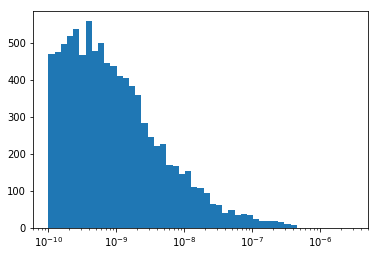

In [33]:
plt.hist(abs(U_2_vo_num - U_2_vo).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(3e-6), 50))
plt.gca().set_xscale("log")

## 实现参考：能量分项对一阶梯度的贡献

有了一阶、二阶 U 矩阵后，应该说绝大多数二阶核坐标梯度的问题都应当得以解决．我们就简单地尝试几个例子．

### $h_{pq}$ 的梯度

我们以前指出，$\frac{\partial}{A_t} h_{\mu \nu} = h_{\mu \nu}^{A_t}$；但由于分子轨道的参与，$\frac{\partial}{A_t} h_{pq} \neq h_{pq}^{A_t}$．事实上，

Yamaguchi (p402, J.3)

$$
\frac{\partial}{\partial A_t} h_{pq} = h_{pq}^{A_t} + U_{mp}^{A_t} h_{mq} + U_{mq}^{A_t} h_{mp}
$$

In [34]:
H_0_mo_diff = NumericDiff(mol, lambda mol : HFHelper(mol).H_0_mo).get_numdif()

可能由于数值 U 矩阵与解析 U 矩阵的偏差较大，因此数值的 $\frac{\partial}{\partial A_t} h_{pq}$ 与解析的 $h_{pq}^{A_t} + U_{mp}^{A_t} h_{mq} + U_{mq}^{A_t} h_{mp}$ 的差距也较大：

In [35]:
H_0_mo_anal = (
    + H_1_mo
    + np.einsum("Atmp, mq -> Atpq", U_1, H_0_mo)
    + np.einsum("Atmq, mp -> Atpq", U_1, H_0_mo)
)
print("Max Absolute Deviation: {:10.4E}".format(abs(H_0_mo_diff - H_0_mo_anal).max()))
print("Avg Absolute Deviation: {:10.4E}".format(abs(H_0_mo_diff - H_0_mo_anal).sum() / H_0_mo_anal.size))

Max Absolute Deviation: 3.2229E-04
Avg Absolute Deviation: 3.9893E-06


### Hamiltonian Core 能量的一阶梯度

我们在这里对[记号](grad_rhf.ipynb#通用记号与程序变量) $\partial_{A_t}$ 与 $\partial_{A_t}^\mathrm{U}$ 小试牛刀．这个记号将会在 GGA 的梯度推导中经常出现，我们需要对这种不太正规的记号熟悉起来．

回顾到电子态能量可以分为 Hamiltonian Core 的贡献 $E_\mathrm{HCore} = h_{\mu \nu} D_{\mu \nu}$ 与 ERI 的贡献 $E_\mathrm{ERI} = D_{\mu \nu} \big( \frac{1}{2} (\mu \nu | \kappa \lambda) - \frac{1}{4} (\mu \kappa | \nu \lambda) \big) D_{\kappa \lambda}$：

In [36]:
def mol_to_engH(mol):
    h = HFHelper(mol)
    return (h.D * h.H_0_ao).sum()

In [37]:
def mol_to_engEri(mol):
    h = HFHelper(mol)
    return (h.D * (0.5 * h.scf_eng.get_j() - 0.25 * h.scf_eng.get_k())).sum()

In [38]:
np.allclose(mol_to_engH(mol) + mol_to_engEri(mol), scf_eng.energy_elec()[0])

True

$\frac{\partial}{\partial {A_t}} E_\mathrm{HCore}$ 的数值结果可以通过下面的代码给出：

In [39]:
engH_diff = NumericDiff(mol, mol_to_engH).get_numdif()
engH_diff

array([[ -1.96343,  -0.61289, -16.80184],
       [ -0.82214,  -6.71323,  16.31066],
       [  2.7118 ,   0.03443,  -0.74837],
       [  0.07377,   7.29169,   1.23955]])

而其解析表达式可以以下面的方法推导．首先，我们展开偏导记号：

\begin{align}
\frac{\partial}{\partial {A_t}} E_\mathrm{HCore} &= (\partial_{A_t} + \partial_{A_t}^\mathrm{U}) (h_{\mu \nu} D_{\mu \nu}) \\
&= \partial_{A_t} h_{\mu \nu} \cdot D_{\mu \nu} + h_{\mu \nu} \cdot \partial_{A_t} D_{\mu \nu} + \partial_{A_t}^\mathrm{U} h_{\mu \nu} \cdot D_{\mu \nu} + h_{\mu \nu} \cdot \partial_{A_t}^\mathrm{U} D_{\mu \nu}
\end{align}

我们知道，$h_{\mu \nu}$ 不包含任何与系数矩阵有关的量；只需要分子与基组，$h_{\mu \nu}$ 就可以被计算得到．因此，$h_{\mu \nu}$ 只具有 Skeleton 导数而不具有 U 导数；即

$$
\partial_{A_t}^\mathrm{U} h_{\mu \nu} = 0
$$

而 $D_{\mu \nu} = 2 C_{\mu i} C_{\nu i}$ 则只有系数矩阵的贡献，不存在 Skeleton 导数而只有 U 导数，即

$$
\partial_{A_t} C_{\mu p} = 0
\quad \mathrm{and} \quad
\partial_{A_t} D_{\mu \nu} = 0
$$

我们很早就知道 $\partial_{A_t} h_{\mu \nu} = h_{\mu \nu}^{A_t}$；对于 $\partial_{A_t}^\mathrm{U} D_{\mu \nu}$，我们利用 Yamaguchi (p398, G.1) 的 U 矩阵的定义式来求解：

$$
\partial_{A_t}^\mathrm{U} D_{\mu \nu} = \partial_{A_t}^\mathrm{U} ( 2 C_{\mu i} C_{\nu i} ) = 2 U_{pi}^{A_t} ( C_{\mu p} C_{\nu i} + C_{\mu i} C_{\nu p} )
$$

因此，

\begin{align}
\frac{\partial}{\partial {A_t}} E_\mathrm{HCore} &= \partial_{A_t} h_{\mu \nu} \cdot D_{\mu \nu} + h_{\mu \nu} \cdot \partial_{A_t}^\mathrm{U} D_{\mu \nu} \\
&= h_{\mu \nu}^{A_t} D_{\mu \nu} + 2 h_{\mu \nu} U_{pi}^{A_t} ( C_{\mu p} C_{\nu i} + C_{\mu i} C_{\nu p} ) \\
&= h_{\mu \nu}^{A_t} D_{\mu \nu} + 4 U_{pi}^{A_t} h_{pi}
\end{align}

In [40]:
engH_anal = (H_1_ao * D).sum(axis=(-1, -2)) + 4 * (U_1[:, :, :, so] * H_0_mo[:, so]).sum(axis=(-1, -2))

In [41]:
np.allclose(engH_anal, engH_diff)

True

<div class="alert alert-info">

**任务**

1. 确实很多时候，$\partial_{A_t}^\mathrm{U} D_{\mu \nu}$ 的表现非常像 $4 U_{pi}^{A_t} C_{\mu p} C_{\nu i}$；至少这一例中，我们拿 $4 U_{pi}^{A_t} C_{\mu p} C_{\nu i}$ 来替代 $\partial_{A_t}^\mathrm{U} D_{\mu \nu}$ 也不会影响 $E_\mathrm{HCore}$ 的一阶梯度．但为何我们还是不能将 $\partial_{A_t}^\mathrm{U} D_{\mu \nu}$ 写为 $4 U_{pi}^{A_t} C_{\mu p} C_{\nu i}$？

</div>

### Hamiltonian Core 能量的二阶梯度

下面我们来考察 $\frac{\partial^2}{\partial A_t \partial B_s} E_\mathrm{HCore}$，并以此来说明我们生成的 $U_{pq}^{A_t B_s}$ 的正确性．

我们刚才已经验证过 $\frac{\partial}{\partial A_t} E_\mathrm{HCore}$ 的正确性了；现在我们可以在函数 `mol_to_engH_grad` 内通过 HFHelper 定义这个计算过程；并以此为基础，通过数值求导生成 `engH_grad_diff` $\frac{\partial^2}{\partial A_t \partial B_s} E_\mathrm{HCore}$：

In [43]:
def mol_to_engH_grad(mol):
    h = HFHelper(mol)
    return (h.H_1_ao * h.D).sum(axis=(-1, -2)) + 4 * (h.U_1[:, :, :, so] * h.H_0_mo[:, so]).sum(axis=(-1, -2))
np.allclose(mol_to_engH_grad(mol), engH_anal)

/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:365: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: Generating total U matrix should be considered as numerical unstable!")


True

In [44]:
engH_grad_diff = NumericDiff(mol, mol_to_engH_grad, deriv=2, p5=True, interval=1e-3).get_numdif()

/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:365: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: Generating total U matrix should be considered as numerical unstable!")


下面我们来简单推导 $\frac{\partial^2}{\partial A_t \partial B_s} E_\mathrm{HCore}$ 的具体算式．按照偏导规则，我们先把偏导记号展开：

$$
(\partial_{B_s} + \partial_{B_s}^\mathrm{U}) \frac{\partial}{\partial {A_t}} E_\mathrm{HCore} = \partial_{B_s} h_{\mu \nu}^{A_t} \cdot D_{\mu \nu} + h_{\mu \nu}^{A_t} \partial_{B_s}^\mathrm{U} D_{\mu \nu}
$$

In [45]:
engH_grad_anal = (
    + np.einsum("ABtsuv, uv -> ABts", H_2_ao, D)
    + 4 * np.einsum("Atpi, Bspi -> ABts", H_1_mo[:, :, :, so], U_1[:, :, :, so])
    + 4 * np.einsum("Bspi, Atpi -> ABts", H_1_mo[:, :, :, so], U_1[:, :, :, so])
    + 4 * np.einsum("qi, Atpi, Bsqp -> ABts", H_0_mo[:, so], U_1[:, :, :, so], U_1)
    + 4 * np.einsum("pq, Atpi, Bsqi -> ABts", H_0_mo, U_1[:, :, :, so], U_1[:, :, :, so])
    + 4 * np.einsum("ai, ABtsai -> ABts", H_0_mo[sv, so], U_2_vo)
    - 2 * np.einsum("ki, ABtski -> ABts", H_0_mo[so, so], Xi_2[:, :, :, :, so, so])
    - 4 * np.einsum("pi, Bspq, Atqi -> ABts", H_0_mo[:, so], U_1, U_1[:, :, :, so])
)

In [46]:
np.allclose(engH_grad_anal, engH_grad_diff, atol=1e-6)

True

同时，我们会注意到 $\frac{\partial^2}{\partial A_t \partial B_s} E_\mathrm{HCore}$ 确实是关于 $A_t, B_s$ 对称的：

In [47]:
np.allclose(engH_grad_anal, engH_grad_anal.transpose(1, 0, 3, 2))

True

<div class="alert alert-info">

**任务**

1. $\frac{\partial^2}{\partial A_t \partial B_s} E_\mathrm{HCore}$ 显然是关于 $A_t, B_s$ 对称的张量，因为偏导可交换性一般来说成立．而我们在数值求得二阶 U 矩阵时，知道 $\partial_{B_s}^\mathrm{U} U_{pi}^{A_t}$ 并不是关于 $A_t, B_s$ 对称的张量；但我们上面在推导时确实使用到了 $\partial_{B_s}^\mathrm{U} U_{pi}^{A_t}$．为何作为结果的 $\frac{\partial^2}{\partial A_t \partial B_s} E_\mathrm{HCore}$ 确实是关于 $A_t, B_s$ 对称的？

</div>